In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import copy
from sarp.utils import load_expert_data_prosthesis, separate_train_test, combine_nets, mini_batch

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)],
        )
    except RuntimeError as e:
        print(e)

current_dir = os.path.dirname(os.path.abspath("3_sarp_repair_partial_obs.ipynb"))

This notebook provides an example of policy repair using SARP for the lower-leg prosthesis. This script assumes that a pre-trained policy and a predictive model are already available. To pre-train a policy for this example run [1_pretrain_policy_partial_obs.py](1_pretrain_policy_partial_obs.py). Also to train a predictive model run [2_pretrain_predictive_model_partial_obs.py](2_pretrain_predictive_model_partial_obs.py). Here are the descriptions of models:
- policy - input: the system full state that includes a history of 10 previous joint sensor and pressure sensor readings - output: ankle angle for the next 30 time steps.
- predictive model - input: states and actions - output: the pressure values for the next 30 time steps. 

#### Laod dataset
First, we load the expert demonstrations for repair.

In [3]:
# load the expert data
data_dir = current_dir + f"/data/expert_data/sample1"

data = load_expert_data_prosthesis(data_dir, 10, 30, type="partial_obs")
(
    s_train,
    a_train,
    p_train,
    s_val,
    a_val,
    p_val,
    s_test,
    a_test,
    p_test,
) = data
s_train = tf.convert_to_tensor(s_train, dtype=tf.float32)
a_train = tf.convert_to_tensor(a_train, dtype=tf.float32)
p_train = tf.convert_to_tensor(p_train, dtype=tf.float32)
s_val = tf.convert_to_tensor(s_val, dtype=tf.float32)
a_val = tf.convert_to_tensor(a_val, dtype=tf.float32)
p_val = tf.convert_to_tensor(p_val, dtype=tf.float32)
s_test = tf.convert_to_tensor(s_test, dtype=tf.float32)
a_test = tf.convert_to_tensor(a_test, dtype=tf.float32)
p_test = tf.convert_to_tensor(p_test, dtype=tf.float32)


2023-07-08 21:23:28.802758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load and megre models
Here, we load the policy and predictive models, then we merge them in a series fashion to be used in repair.

In [4]:
# load the models
model_policy_orig = keras.models.load_model(
    current_dir
    + f"/trained_models/policy_partial_obs/model"
    )
model_predictive = keras.models.load_model(
    current_dir
    + f"/trained_models/predictive_partial_obs/model"
    )

# combine the models, state_indices_passed is the indices of the states that are passed to the predictive model
model_combined = combine_nets(model_policy_orig, model_predictive, state_indices_passed=[s_train.shape[1]-i for i in range(4, 0, -1)])

# keep only the policy part of the combined model to be trained
for layer in model_combined.layers:
    if layer.name.split("_")[0] == "policy":
        layer.trainable = True
    else:
        layer.trainable = False
_,_ = model_combined.predict(s_train[0:1])

Model: "repair_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 policy_layer_1 (Dense)      multiple                  42148     
                                                                 
 policy_layer_2 (Dense)      multiple                  1057812   
                                                                 
 policy_layer_3 (Dense)      multiple                  30870     
                                                                 
 Predictive_layer_1 (Dense)  multiple                  17920     
                                                                 
 Predictive_layer_2 (Dense)  multiple                  262656    
                                                                 
 Predictive_layer_3 (Dense)  multiple                  61560     
                                                                 
Total params: 1,472,966
Trainable params: 1,472,966
No

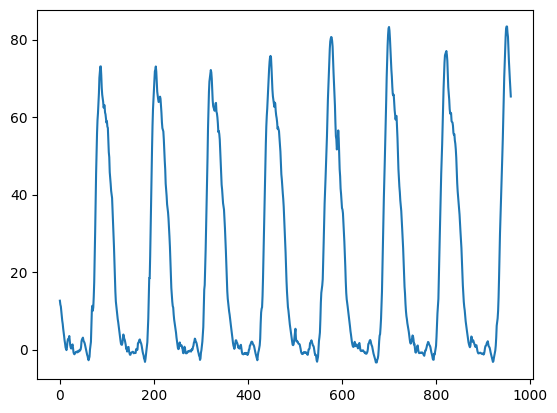

In [5]:
plt.plot(model_combined.predict(s_train)[1][:,0])

#### Define the optimization parameters

We first define the loss function, lagrangian penalty terms and the quadratic penalty terms. We assum the following constraint:
1. Constraint on pressure: $p\leq50$         $\Longrightarrow g_{pres} = ReLU(p-50)$

The augmented loss is formulated as 

\begin{align} 
\mathcal{L}^a =  \mathcal{L}_{original} -\lambda_{pres} g_{pres} + \frac{\mu_{pres}}{2}g^2_{pres}\nonumber
\end{align}

In [6]:
# optimization parameters
batch_size = 32
epochs = 100
params = {
    "lambda_pres": tf.constant(0.0, dtype="float32"),
    "mu_pres": tf.constant(5.0, dtype="float32"),
    "eta_pres": tf.constant(0.001, dtype="float32"),
    "beta_pres": tf.constant(5.0, dtype="float32"),
}
learning_rate = 0.00001

# create data batches
batches = mini_batch(
    tf.concat(s_train,0),
    tf.concat(a_train,0), 
    tf.concat(p_train,0), 
    batch_size,
    )


In [7]:
def original_loss(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

def pres_penalty(y):
    return tf.reduce_sum(tf.square(tf.nn.relu(y[:, :4] - 50)))

def pres_lagrangian(y):
    return tf.reduce_sum(tf.nn.relu(y[:, :4] - 50))

def augmented_loss(
    s, a, params
):
    a_pred, p_pred = model_combined(s)
    loss_value = (
            100 * original_loss(a, a_pred)
            - params["lambda_pres"] * pres_lagrangian(p_pred)
            + params["mu_pres"] / 2 * pres_penalty(p_pred)
        )
    return (
            loss_value,
            original_loss(a, a_pred),
            pres_lagrangian(p_pred),
        )

Now we define the optimizer and the policy update step.

In [8]:
class LearningRateScheduler():
    def __init__(self, optimizer, lr_min=5e-5, decay=0.1, patience=10, loss_tol=0.0001):
        self.lr_min = lr_min
        self.patience = patience
        self.decay = decay
        self.optimizer = optimizer
        self.loss_tol = loss_tol
        self.counter = 0
        self.loss_prev = 10000

    def on_batch_end(self, loss):
        if self.loss_prev - loss > self.loss_tol:
            pass
        else:
            self.counter += 1
            if self.counter > self.patience:
                self.counter = 0
                new_lr = self.optimizer.learning_rate * self.decay
                if new_lr.numpy() >= self.lr_min:
                    self.optimizer.learning_rate.assign(new_lr)
        
        self.loss_prev = loss


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
lr_scheduler = LearningRateScheduler(optimizer, lr_min=5e-5, decay=0.1, patience=10, loss_tol=0.0001)

@tf.function
def train_step(
    s, a, params
):
    with tf.GradientTape() as tape:
        loss_value, _, _ = augmented_loss(
            s, a, params
        )
    grads = tape.gradient(loss_value, model_combined.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_combined.trainable_variables))
    return loss_value

#### Repair the policy 

Here we repair the policy in the loop and adjust the lagrangian multiplier and penalty coefficient accordingly. 

In [9]:
class MetricCollector():
    def __init__(self):
        self.loss = {'train':[], 'test':[]}
        self.pres = {'train':[], 'test':[]}
        self.best_weights = []
    
    def update_state(self, s_train, a_train, s_test, a_test, params):
        _, loss_train, pres_train = augmented_loss(
            s_train, a_train, params
        )
        _, loss_test, pres_test = augmented_loss(
            s_test, a_test, params
        )
        self.loss['train'].append(loss_train.numpy())
        self.loss['test'].append(loss_test.numpy())
        self.pres['train'].append(pres_train.numpy())
        self.pres['test'].append(pres_test.numpy())
    
    def save_best_model(self, model):
        if self.pres['test'][-1] == min(self.pres['test']):
            self.best_weights = model.get_weights()[:(len(model.policy_arch)-1)*2]

    def plot(self):
        _, ax = plt.subplots(2,1, figsize=(10,10))
        ax[0].plot(self.loss['train'], label='train')
        ax[0].plot(self.loss['test'], label='test')
        ax[0].set_ylabel('loss')
        ax[0].legend()
        ax[1].plot(self.pres['train'], label='train')
        ax[1].plot(self.pres['test'], label='test')
        ax[1].set_ylabel('pressure')
        ax[1].legend()
        plt.show()

class Verbose():
    def __init__(self, metric_collector, optimizer, epochs):
        self.metric_collector = metric_collector
        self.optimizer = optimizer
        self.epochs = epochs
        self.best_model = None

    def on_batch_end(self, epoch, model):
        print(f"e: {epoch}/{self.epochs}, lr: {self.optimizer.learning_rate.numpy():.6f}, loss: {self.metric_collector.loss['train'][-1]:.4f}, pres: {self.metric_collector.pres['train'][-1]:.4f}, loss_val: {self.metric_collector.loss['test'][-1]:.4f}, pres_val: {self.metric_collector.pres['test'][-1]:.4f}")


In [10]:
metric_collector = MetricCollector()
verbose = Verbose(metric_collector, optimizer, epochs)
for epoch in range(epochs):
    epoch_loss = 0
    for batch in batches:
        batch_loss = train_step(batch[0], batch[1], params)
        epoch_loss += batch_loss

    # update stats
    metric_collector.update_state(
        tf.concat(s_train,0), 
        tf.concat(a_train,0), 
        tf.concat(s_test,0), 
        tf.concat(a_test,0), 
        params,
    ) 

    # save best model
    metric_collector.save_best_model(model_combined)

    # update parameters
    if (epoch + 1) % 10 == 0:
        params["lambda_pres"] = (
            params["lambda_pres"]
            + params["eta_pres"] * metric_collector.pres["train"][-1]
        )
        params["mu_pres"] = params["mu_pres"] * params["beta_pres"]
    
    # print stats
    verbose.on_batch_end(epoch+1, model_combined)
    
    # update learning rate
    lr_scheduler.on_batch_end(metric_collector.pres['test'][-1])

e: 1/100, lr: 0.000010, loss: 3.1108, pres: 6379.5615, loss_val: 14.5360, pres_val: 2985.4414
e: 2/100, lr: 0.000010, loss: 3.2614, pres: 4567.9155, loss_val: 15.2727, pres_val: 2233.6172
e: 3/100, lr: 0.000010, loss: 3.4576, pres: 3451.1816, loss_val: 15.8320, pres_val: 1834.3059
e: 4/100, lr: 0.000010, loss: 3.6306, pres: 2737.5730, loss_val: 16.2523, pres_val: 1638.0255
e: 5/100, lr: 0.000010, loss: 3.7752, pres: 2258.2065, loss_val: 16.5846, pres_val: 1515.2344
e: 6/100, lr: 0.000010, loss: 3.8979, pres: 1918.9673, loss_val: 16.8733, pres_val: 1408.0386
e: 7/100, lr: 0.000010, loss: 4.0033, pres: 1665.5990, loss_val: 17.1308, pres_val: 1311.5033
e: 8/100, lr: 0.000010, loss: 4.0969, pres: 1466.9448, loss_val: 17.3715, pres_val: 1223.8916
e: 9/100, lr: 0.000010, loss: 4.1784, pres: 1311.8368, loss_val: 17.5882, pres_val: 1143.5886
e: 10/100, lr: 0.000010, loss: 4.2512, pres: 1182.9619, loss_val: 17.7862, pres_val: 1069.4639
e: 11/100, lr: 0.000010, loss: 4.7968, pres: 837.1770, loss

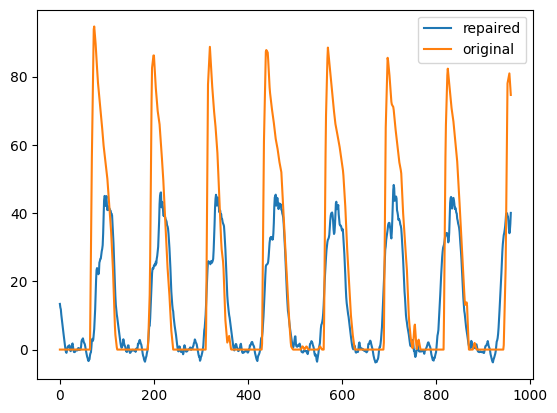

In [11]:
plt.plot(model_combined.predict(s_train)[1][:,0], label='repaired')
plt.plot(p_train[:,0], label='original')
plt.legend()
plt.show()

#### Save model

In [14]:
if not os.path.exists(current_dir + f"/trained_models/repaired_policy_partial_obs"):
    os.makedirs(current_dir + f"/trained_models/repaired_policy_partial_obs")

counter = 0
for l in range(len(model_policy_orig.layers)):
    if (len(model_policy_orig.layers[l].get_weights())) > 0:
        model_policy_orig.layers[l].set_weights(
            [metric_collector.best_weights[2*counter], metric_collector.best_weights[2*counter+1]]
        )
        counter += 1

keras.models.save_model(
    model_policy_orig,
    f"{current_dir}/trained_models/repaired_policy_partial_obs/model",
    overwrite=True,
    include_optimizer=False,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=False,
)

INFO:tensorflow:Assets written to: /Users/keyvanmajd/Documents/SARP/examples/2_lower_leg_prosthesis/trained_models/repaired_policy_partial_obs/model/assets
